In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import pickle as pickle
import glob
import settings
%matplotlib inline

#### Load data from pickle files

In [3]:
data = pickle.load( open( "camera_calibration.p", "rb" ) )
camera_matrix = data['mtx']
dist_coeffs = data['dist']

perspective_transform_data = pickle.load(open("perspective.p", 'rb'))
x_pixels_per_meter = perspective_transform_data['x_pixels_per_meter']
y_pixels_per_meter = perspective_transform_data['y_pixels_per_meter']
M = perspective_transform_data['homography_matrix']
src_pts = perspective_transform_data['source_points']

### Image example

In [4]:
import os
test_images = []
for file in glob.glob('./test_images/test*'):
    print('file is : ', file)
    test_images.append(file)

file is :  ./test_images/test1.jpg
file is :  ./test_images/test5.jpg
file is :  ./test_images/test6.jpg
file is :  ./test_images/test2.jpg
file is :  ./test_images/test4.jpg
file is :  ./test_images/test3.jpg


In [5]:
test_images.append('./test_images/straight_lines1.jpg')
test_images.append('./test_images/straight_lines2.jpg')

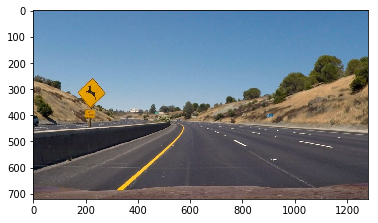

In [6]:
test_1 = mpimg.imread(test_images[3])
plt.imshow(test_1)

In [7]:
# import numpy as np
# import cv2
# im = cv2.imread(test_images[0])
# imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# ret,thresh = cv2.threshold(imgray,127,255,0)
# print('ret: ', ret)
# print('thresh: ', thresh.
#       shape)
# im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# print('im2: ', im2.shape)
# print('contours: ', len(contours))
# plt.imshow(im2)
# cv2.drawContours(im, contours, -1, (0, 255, 0), 3)
# # plt.imshow(im)
# area = cv2.contourArea(contours[0])
# print('area: ', area)

### Lane Line Finder

In [30]:
class LaneLineFinder():
    """
    This class performs the individual calculations on a single lane line
    """
    def __init__(self, img_size, x_pixels_per_meter, y_pixels_per_meter, kind = 'none'):
        self.img_size = img_size
        self.x_pixels_per_meter = x_pixels_per_meter
        self.y_pixels_per_meter = y_pixels_per_meter
        self.kind = kind # specify left or right lane
        self.line_mask = np.ones((img_size[1], img_size[0]), dtype=np.uint8) # create 2D line mask
        self.found = False
        self.recent_centers = []
        self.smooth_factor = 15
        
    def find_lane_line(self, mask, FLAG):
        """
        Perform convolutional sliding window
        Identify points of interest and save them
        Then pass the saved points to fit_lane_line where you apply polynomial fit
        input: mask (shape [500, 600])
        """
        img_width = self.img_size[0] # 500
        img_height = self.img_size[1] # 600

#         self.window_width = 40
#         self.window_height = 70
        
        self.window_width = 40
        self.window_height = 70

        window_centroids = self.find_window_centroids(mask, 
                                                 window_width = self.window_width, 
                                                 window_height = self.window_height,
                                                 margin_width = 30,
                                                 margin_height = 35,
                                                 FLAG = FLAG)
        
        points, x_left_right = self.get_line_pts(mask, window_centroids)
        
        weighted, tmp, mask =  draw_lines_weighted(points, mask)
        
        # TODO: Finish fit_line instantiation
        left_lane, right_lane = self.fit_lines(window_centroids, 
                                               x_left_right[0], 
                                               x_left_right[1], 
                                               self.window_width, 
                                               self.window_height)
        
        
        road_lines = self.draw_lines(left_lane, right_lane)
        # points now is an array containing [left_points, right_points]
        return road_lines
        
    
    def find_window_centroids(self, mask, 
                          window_width, 
                          window_height, 
                          margin_width,
                          margin_height,
                          FLAG):
        img_width = self.img_size[0] # 500
        img_height = self.img_size[1] # 600

        window = np.ones((window_width))
        n_vertical_slices = img_height // window_height # 8 iterations
        window_centroids = []
        
        left_x_vals = []
        right_x_vals = []
        
        # sum up the pixels within the bottom box
        # go down 3/4 into height

        v_step = img_height // window_height
        window_vertical_start = int((3/4) * img_height)
        window_horizontal_start = int(img_width/2)


        l_sum = np.sum(mask[window_vertical_start:, :window_horizontal_start], axis = 0)
        l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2

        r_sum = np.sum(mask[window_vertical_start:, window_horizontal_start:], axis = 0)
        r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + img_width/2

        left_x_vals.append(l_center)
        right_x_vals.append(r_center)
        
        
#         window_centroids.append([l_center, r_center])
        for level in range(1, n_vertical_slices):
            # convolve window with vertical slice of image
            # first sum up the image vertically
            window_start_vertical = img_height - (level + 1) * (window_height)
            window_end_vertical = img_height - (level * window_height)

            image_layer = np.sum(mask[window_start_vertical : window_end_vertical,:], axis = 0)
            conv_signal = np.convolve(window, image_layer)

            # Use past centroid as a reference to find the best centroid within a margin
            offset = int(window_width / 2)
            l_min_index = int(max(l_center + offset - margin_width, 0))
            l_max_index = int(min(l_center + offset + margin_width, img_width))
            l_center = np.argmax(conv_signal[l_min_index: l_max_index]) + l_min_index - offset

            # look near the first centroid for the right centroids
            r_min_index = int(max(r_center + offset - margin_width, 0))
            r_max_index = int(min(r_center + offset + margin_width, img_width))
            r_center = np.argmax(conv_signal[r_min_index: r_max_index]) + r_min_index - offset
            
            left_x_vals.append(l_center)
            right_x_vals.append(r_center)
            
        
        left_centers = moving_average_scale(left_x_vals)
        right_centers = moving_average_scale(right_x_vals)
    
        centroids = [[a,b] for a,b in zip(left_centers, right_centers)]        
        print('centroids inside find_window_centroids: ', centroids)
        return centroids

    
    def fit_lines(self, window_centroids, leftx, rightx, window_width, window_height):
        
        if len(leftx) == len(rightx):
            vert_start = self.img_size[1] - window_height/2
            vert_stop = window_height
            y_values = np.linspace(vert_start, vert_stop, len(leftx), dtype = np.float32)

        
        # fit to a polynomial (ax^2 + bx + c)
        left_fit = np.polyfit(y_values, leftx, 2)
        left_fitx = left_fit[0] * (y_values**2) + left_fit[1] * y_values + left_fit[2]
        left_fitx = np.array(left_fitx, np.int32)
        
        right_fit = np.polyfit(y_values, rightx, 2)
        right_fitx = right_fit[0] * (y_values**2) + right_fit[1] * y_values + right_fit[2]
        right_fitx = np.array(right_fitx, np.int32)
        shift = 0
        
        left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/10 + shift, left_fitx[::-1] + window_width/10 + shift), axis = 0),
                            np.concatenate((y_values, y_values[::-1]), axis = 0))), dtype = np.int32)
        
        right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/10 + shift, right_fitx[::-1] + window_width/10 + shift), axis = 0),
                            np.concatenate((y_values, y_values[::-1]), axis = 0))), dtype = np.int32)

        
#         both_lanes = np.array(list(zip(left_fitx, right_fitx)), dtype = np.int32)
#         print('lanes shape: ', both_lanes.shape)
#         return both_lanes[0], both_lanes[1]
        return left_lane, right_lane
    
    def draw_lines(self, left_lane, right_lane):
        lanes = np.zeros((self.img_size[1], self.img_size[0], 3), dtype = np.uint8)
        
#         left_lane = left_lane.astype(np.uint8)
#         right_lane = right_lane.astype(np.uint8)
        
#         # fill in the lane lines
#         cv2.polylines()
#         es 	( 	InputOutputArray  	img,
# 		InputArrayOfArrays  	pts,
# 		bool  	isClosed,
# 		const Scalar &  	color,
# 		int  	thickness = 1,
# 		int  	lineType = LINE_8,
# 		int  	shift = 0 
        
#         cv2.polylines(lanes, [left_lane], isClosed = False, thickness = 1, color = [255, 0, 0])
#         cv2.polylines(lanes, [right_lane], isClosed = False, thickness = 1, color = [0, 255, 0])
        
        
        cv2.fillPoly(lanes, [left_lane], color = [255, 0, 0])
        cv2.fillPoly(lanes, [right_lane], color = [0,255, 0])
        return lanes


    def get_line_pts(self, mask, window_centroids):
        """
        Here we find the points that will be used to draw the left and right windows
        """
        

        
        # Points we will use for drawing on each level
        left_points = np.zeros_like(mask)
        right_points = np.zeros_like(left_points)
        
        left_x = []
        right_x = []
        
        for level in range(0, len(window_centroids)):
            # window_mask if a function to draw window boxes
            left_x.append(window_centroids[level][0])
            right_x.append(window_centroids[level][1])
            
            left_mask = draw_window_box(mask, self.window_width, self.window_height, 
                                        window_centroids[level][0],
                                        level)
            right_mask = draw_window_box(mask, self.window_width, self.window_height, 
                                        window_centroids[level][1],
                                        level)
            
            left_points[(left_points == 255) | ((left_mask == 1))] = 255
            right_points[(right_points == 255) | ((right_mask == 1))] = 255
            
        return [left_points, right_points], [left_x, right_x]
        
   

In [42]:
import math
def moving_average_scale(a):
    mean = np.mean(a)
    std = np.std(a)
    standard = [((x - mean) / std)for x in a]
    results = []
    for x, y in zip(a, standard):
        results.append(math.ceil(x - y))
    return results

In [43]:
def draw_window_box(mask, window_width, window_height, window_centroid, level):
    box = np.zeros_like(mask)
    window_start_vertical = int(mask.shape[0] - (level + 1) * (window_height))
    window_stop_vertical = int(mask.shape[0] - (level * window_height))

    window_start_horizontal = max(0, int(window_centroid - window_width))
    window_stop_horizontal = min(int(window_centroid + window_width), mask.shape[1])

    box[window_start_vertical: window_stop_vertical, window_start_horizontal: window_stop_horizontal] = 1
    return box

In [44]:
def draw_lines_weighted( points, mask):
        """
        Draw lines according to binary image mask weight
        """
    
        template = np.asarray(points[0] + points[1]).astype(np.uint8)
        tmp = np.zeros((template.shape[0], template.shape[1], 3)).astype(np.uint8)
        # make window red
        
        tmp[:,:,0] = np.zeros_like(template)
        tmp[:,:,1] = template[:,:]
        tmp[:,:,2] = tmp[:,:,0]
        
        combine_mask = np.array(cv2.merge((mask, mask, mask))).astype(np.uint8)
        weighted = cv2.addWeighted(combine_mask, 1, tmp, 0.5, 0.0)
        
        return weighted, tmp, mask
        

### Lane Finder

* For type uint8 LAB images the range is from (0, 255) for each channel
* Isolate green stuff by looking at the l in LAB. L = lightness,
* a: color opponents green-red
* b: color opponents blue-yellow, yellow has positive values, blue has negative values
        

In [45]:
laneFinder = LaneFinder(settings.ORIGINAL_SIZE, settings.UNWARPED_SIZE, camera_matrix, dist_coeffs, 
                        M, x_pixels_per_meter, y_pixels_per_meter)

In [46]:
im = mpimg.imread(test_images[3])
(road_lines, warped, unwarped_lines, weighted_warped, original_unweighted) = laneFinder.find_lane(im)

centroids inside find_window_centroids:  [[185, 355], [157, 354], [155, 355], [182, 338], [160, 349], [157, 349], [150, 347], [149, 351]]
lines shape in add_weighted:  (600, 500, 3)
base shape in add_weighted:  (600, 500, 3)
lines shape in add_weighted:  (720, 1280, 3)
base shape in add_weighted:  (720, 1280, 3)


shape:  (600, 500, 3)


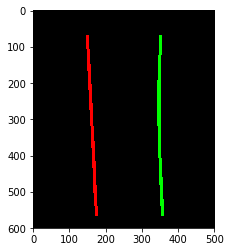

In [47]:
plt.imshow(road_lines)
print('shape: ', road_lines.shape)

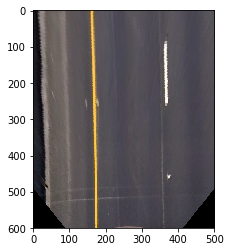

In [48]:
plt.imshow(warped)

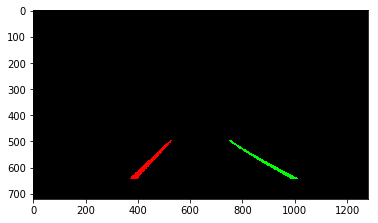

In [49]:
plt.imshow(unwarped_lines)

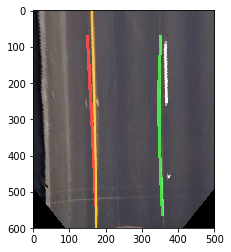

In [50]:
plt.imshow(weighted_warped)

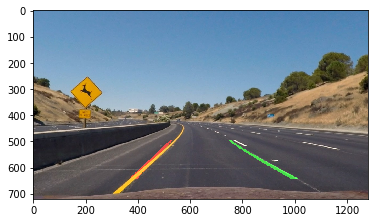

In [51]:
plt.imshow(original_unweighted)

In [41]:
class LaneFinder():
    def __init__(self, 
                 img_size, 
                 warped_size, 
                 camera_matrix, 
                 dist_coeffs,
                 transform_matrix,
                 x_pixels_per_meter, y_pixels_per_meter):
        self.img_size = img_size
        self.warped_size = warped_size
        self.camera_matrix = camera_matrix
        self.dist_coeffs = dist_coeffs
        self.transform_matrix = transform_matrix
        self.x_pixels_per_meter = x_pixels_per_meter
        self.y_pixels_per_meter = y_pixels_per_meter
        self.roi_mask = np.ones((self.warped_size[1], self.warped_size[0],3), dtype=np.uint8)
        self.mask = np.zeros((self.warped_size[1], self.warped_size[0], 3), dtype = np.uint8)
        self.real_mask = np.zeros((self.warped_size[1], self.warped_size[0],3), dtype = np.uint8)
        self.left_line = LaneLineFinder(warped_size, x_pixels_per_meter, y_pixels_per_meter, kind = 'left')
        self.right_line = LaneLineFinder(warped_size, self.x_pixels_per_meter, self.y_pixels_per_meter, kind = 'right') 
        self.found_both = False
        
        
    def warp(self, img):
        return cv2.warpPerspective(img, self.transform_matrix, self.warped_size, 
                                   flags=cv2.WARP_FILL_OUTLIERS + cv2.INTER_NEAREST)
    
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.transform_matrix, self.img_size, 
                                   flags = cv2.WARP_FILL_OUTLIERS + cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)
    
    def undistort(self, img):
        return cv2.undistort(img, self.camera_matrix, self.dist_coeffs)
    
    def add_weighted(self, base, lines):
        print('lines shape in add_weighted: ', lines.shape)
        print('base shape in add_weighted: ', base.shape)
        return cv2.addWeighted(base, 1.0, lines, .6, 0.0)
    
    def find_lane(self, image, distorted = True, FLAG = False):
        """
        Pipeline:
        1) Undistort
        2) Perspective Transform
        3) Blur
        4) Convert to HLS and LAB and use the Luminance channel to identify yellow lines
        """
        if FLAG == True:
            self.left_line.reset_lane_line()
            self.right_line.reset_lane_lin()
        
        # 1) Undistort the image
        # TODO: Add conditional to flag distortion
        img = self.undistort(image)
        
        # 2) Apply perspective transform
        warped = self.warp(img)
        
        # 3) Blur
        blur_kernel = 5
        img_hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
        img_lab = cv2.cvtColor(warped, cv2.COLOR_RGB2LAB)
        
        img_hls = cv2.medianBlur(img_hls, blur_kernel)
        img_lab = cv2.medianBlur(img_lab, blur_kernel)
        
        # Get structuring element for morph transforms
        # note: Select structuring element to be large enough so that it won't fit inside the objects to be removed
        large_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (29, 29))
        small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
                
        # The road is dark, so extract bright regions out of the image
        # If L in HLS is greater than 190 then it is bright
        # Also filter out low saturation < 50
        hls_filter = cv2.inRange(img_hls, (0, 0, 50), (30, 192, 255))
        
        yellow = hls_filter & (img_lab[:,:,2].astype(np.uint8) > 127)
            
        # Logical not means find inverse because later on we will combine this mask with the self.mask
        roi_mask = np.logical_not(yellow).astype(np.uint8)
        # cut out the bright stuff
        roi_mask = (roi_mask & (img_hls[:,:,1] < 245)).astype(np.uint8)
        
        # perform OPEN morphology (erosion + dilation) to reduce noise
        roi_mask = cv2.morphologyEx(roi_mask, cv2.MORPH_OPEN, small_kernel)
        
        # roi_mask is a binary mask
        # perform Dilation morphology for enhancement on larger features
        roi_mask = cv2.dilate(roi_mask, large_kernel)


        self.roi_mask[:,:,0] = (self.left_line.line_mask | self.right_line.line_mask) & roi_mask
        self.roi_mask[:,:,1] = self.roi_mask[:,:,0]
        self.roi_mask[:,:,2] = self.roi_mask[:,:,0]

    
        # perform tophat (original - opening)
        tophat_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 3))
        black = cv2.morphologyEx(img_lab[:,:,0], cv2.MORPH_TOPHAT, tophat_kernel)
        lanes = cv2.morphologyEx(img_hls[:,:,1], cv2.MORPH_TOPHAT, tophat_kernel)
        
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
        yellow_lanes = cv2.morphologyEx(img_lab[:,:,2], cv2.MORPH_TOPHAT, rect_kernel)
        
        # Adaptive thresholding
        self.mask[:,:,0] = cv2.adaptiveThreshold(black, 50, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, -6)
        self.mask[:,:,1] = cv2.adaptiveThreshold(lanes, 60, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -4)
        self.mask[:,:,2] = cv2.adaptiveThreshold(yellow_lanes, 60, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -1.5)

        diff_mask = self.mask * self.roi_mask
        small_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 2))
        
        # grab any values that are nonzero
        self.total_mask = np.any(diff_mask, axis = 2).astype(np.uint8)
        # erosion on total_mask to reduce noise
        self.total_mask = cv2.morphologyEx(self.total_mask, cv2.MORPH_ERODE, small_ellipse)
        
        left_mask = self.total_mask
        right_mask = self.total_mask
        if self.right_line.found:
            # left mask is NOT the right line mask and not the right line's other mask, this mask is binary
            left_mask = self.total_mask & np.logical_not(self.right_line.line_mask) & self.right_line.other_mask
        if self.left_line.found:
            right_mask = self.total_mask & np.logical_note(self.left_line.lin_mask) & self.left_line.other_mask
            
#         self.left_line.find_lane_line(left_mask, FLAG)
#         self.right_line.find_lane_line(right_mask, FLAG)
        
        road_lines = self.left_line.find_lane_line(left_mask, FLAG)
        unwarped_lines = self.unwarp(road_lines)
        
        weighted_warped = self.add_weighted(warped, road_lines)
        
        
        original_weighted = self.add_weighted(img, unwarped_lines)
        
        return (road_lines, warped, unwarped_lines, weighted_warped, original_weighted)
        
        
        # add weighted image 
        
        
        if self.right_line.found and self.left_line.found:
            print('we found both lane lines')
    

In [ ]:
laneFinder = LaneFinder(settings.ORIGINAL_SIZE, settings.UNWARPED_SIZE, camera_matrix, dist_coeffs, 
                        M, x_pixels_per_meter, y_pixels_per_meter)

In [ ]:
total_mask = laneFinder.find_lane(test_1)
plt.imshow(total_mask)

In [ ]:
laneFinder.right_line

### Thresholding functions

In [ ]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

In [ ]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # sobel x and y
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)

    sobel_xy = np.sqrt(sobelx**2 + sobely**2)
    print('sobel_xy: ', sobel_xy)
    print(':: ',np.max(sobel_xy, axis = 0))
    print('sobel_xy: ', sobel_xy.shape)
    sf = np.max(sobel_xy/255)
    gradmag = (sobel_xy/sf).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

In [ ]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_x= np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    
    
    direction = np.arctan2(abs_y, abs_x)
    
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

In [ ]:
def color_threshold(img, sthresh=(0, 255), vthresh = (0, 255)):
    """
    This function takes in two thresholds, s in HLS and v in HSV and the image and it 
    returns the combination output binary of both gradients
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    
    # s channel
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s > sthresh[0]) & (s <= sthresh[1])] = 1
    
    # v channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # isolate v channel
    v = hsv[:,:,2]
    v_binary = np.zeros_like(v)
    v_binary[(v > vthresh[0]) & (v <= vthresh[1])] = 1

    # create combination of both binaries as output
    output_binary = np.zeros_like(s)
    output_binary[(s_binary == 1) | (v_binary == 1)] = 255

    return output_binary